# Twitter Sentiment Analysis

> Di project ini saya akan mencoba melakukan sentiment analysis menggunakan tweet-tweet yang berhubungan dengan kata `AlbertEinstein`. 

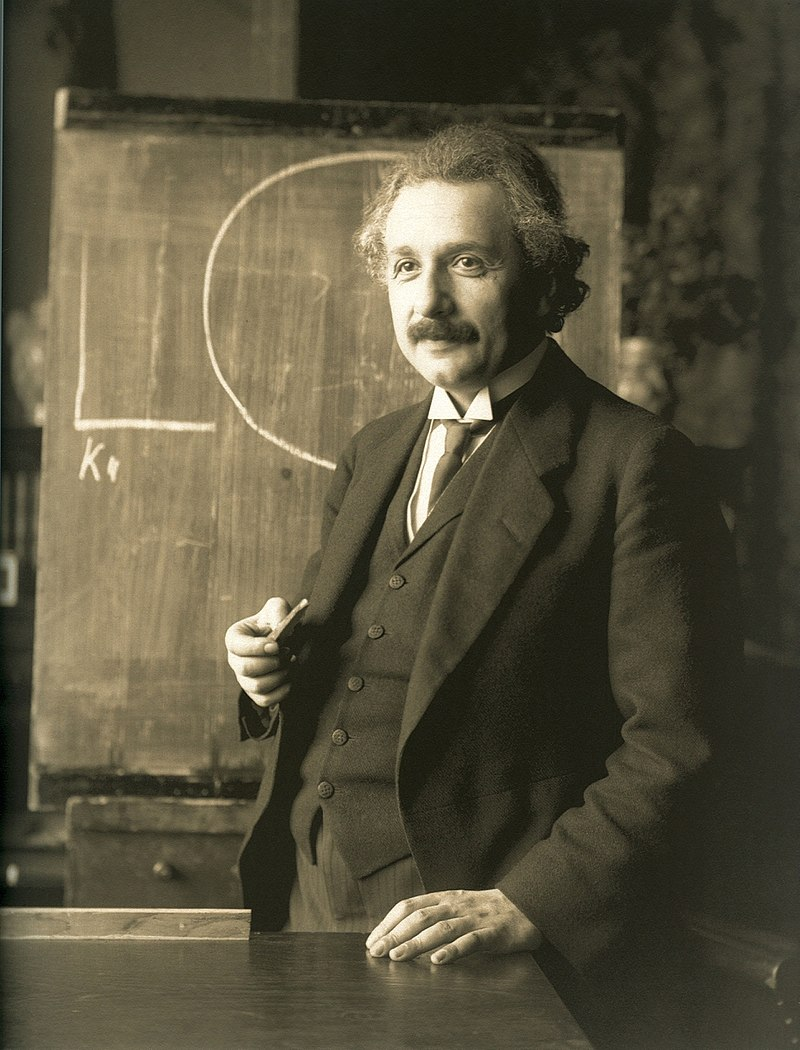

In [293]:
from IPython.display import Image

Image(filename='einstein.jpg', height = 200, width = 300) 

source : http://www.bhm.ch/de/news_04a.cfm?bid=4&jahr=2006

In [267]:
import tweepy
from twitter_key import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
import string
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [268]:
auth = tweepy.OAuthHandler(API_key, API_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [269]:
tweets = api.user_timeline(screen_name = 'AlbertEinstein', count = 200, lang = 'en', tweet_mode = 'extended')

Saya memilih kata `AlbertEinstein` karena alasan personal, mengingat saya dulu kuliah fisika dan masuk ke peminatan fisika teori. Saya juga beruntung dapat belajar Relativitas umum saat kuliah, dimana itu adalah salah satu karya Einstein yang paling saya kagumi. 

In [270]:
for tweet in tweets[:5]:
    print(tweet['full_text'] + '\n')

Fan art Friday! https://t.co/LvEbq7BhNQ

A Black Hole’s Lunch Provides a Treat for Astronomers (via @nytimes)
https://t.co/DOEaKjtAj5

RT @overbye: Fast times in a black hole mosh pit
 https://t.co/3CH0QjV1ES

Planets are forming around young stars far faster than scientists expected, arising in a cosmic eye blink of less than half a million years, according to a new study. https://t.co/8YkCCq8xC2

RT @QuantaMagazine: From 2017: Physicists have found evidence of a mathematical structure that encompasses all quantum theories: https://t.…



In [271]:
df = pd.DataFrame([tweet['full_text'] for tweet in tweets], columns = ['Tweets'])

df.head()

,Tweets
0,Fan art Friday! https://t.co/LvEbq7BhNQ
1,A Black Hole’s Lunch Provides a Treat for Astr...
2,RT @overbye: Fast times in a black hole mosh p...
3,Planets are forming around young stars far fas...
4,RT @QuantaMagazine: From 2017: Physicists have...


In [272]:
def clean(txt):
    txt = re.sub('@[A-Za-z0–9]+', '', txt) #Menghilangkan mention
    txt = re.sub('https?:\/\/\S+', '', txt) # Menghilangkan Link
    txt = re.sub('RT[\s]+', '', txt) # Menghilangkan RT
    txt = re.sub('#', '', txt) #Menghilangkan HashTag
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = str(txt).lower()
    return txt

df['Tweets'] = df['Tweets'].apply(clean)

In [273]:
df

,Tweets
0,fan art friday
1,a black hole’s lunch provides a treat for astr...
2,fast times in a black hole mosh pit\n
3,planets are forming around young stars far fas...
4,from 2017 physicists have found evidence of a...
...,...
195,how albert einsteins son tamed the mississippi...
196,our universe resides in the center of a black ...
197,wednesdaywisdom “i have little patience for sc...
198,do neutron stars gain matter if so do they jus...


In [274]:
def re_stopword(x):
    return [y for y in x if y not in stopwords.words('english')] #membuang kata-kata tidak 'penting'

In [275]:
df['split'] = df['Tweets'].apply(lambda x : x.split())
df['split'] = df['split'].apply(lambda x:re_stopword(x))

In [276]:
top = Counter([i for j in df['split'] for i in j])
temp = pd.DataFrame(top.most_common(10))
temp = temp.iloc[1:,:]
temp.columns = ['Word', 'Counts']
print('Top 10 Most Common Words')
temp

Top 10 Most Common Words


,Word,Counts
1,via,38
2,black,21
3,new,21
4,albert,21
5,universe,19
6,scientists,14
7,einsteins,14
8,theory,14
9,holes,13


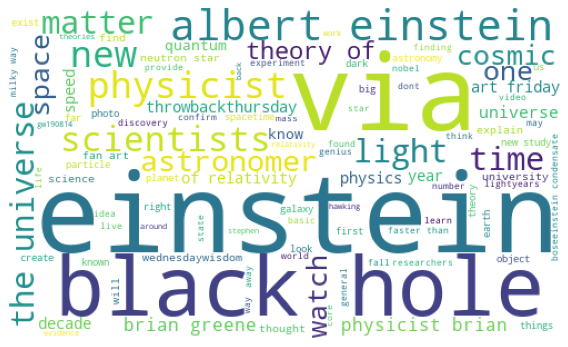

In [277]:
allWords = ''.join(i for i in df['Tweets'])
wordsCloud = WordCloud(max_font_size=100, max_words=100, width=500, height=300, background_color = 'white').generate(allWords)

plt.figure(figsize=(8,8))
plt.imshow(wordsCloud)
plt.axis("off")
plt.tight_layout()
plt.show()

> Dari gambar di atas, dapat dilihat kontribusi-kontribusi Einstein di dunia fisika, seperti misalnya relativitas umum dan lubang hitam. Terlihat juga ada kata Hawking dan Brian Greene di atas, dua fisikawan yang saya sangat kagumi. Menarik bisa melihat ada kata 'confirm' di atas, mungkin ini berhubungan dengan penemuan beberapa tahun yang lalu tentang gelombang gravitasi. 

In [278]:
def subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def polarity(txt):
    return TextBlob(txt).sentiment.polarity

In [279]:
df['Subjectivity'] = df['Tweets'].apply(subjectivity)
df['Polarity'] = df['Tweets'].apply(polarity)

In [280]:
df.head()

,Tweets,split,Subjectivity,Polarity
0,fan art friday,"[fan, art, friday]",0.000000,0.000000
1,a black hole’s lunch provides a treat for astr...,"[black, hole’s, lunch, provides, treat, astron...",0.433333,-0.166667
2,fast times in a black hole mosh pit\n,"[fast, times, black, hole, mosh, pit]",0.516667,0.016667
3,planets are forming around young stars far fas...,"[planets, forming, around, young, stars, far, ...",0.414646,-0.016162
4,from 2017 physicists have found evidence of a...,"[2017, physicists, found, evidence, mathematic...",0.000000,0.000000


In [281]:
def sentiment(x):
    if x > 0:
        return 'positive'
    elif x < 0:
        return 'negative'
    else:
        return 'neutral'

In [282]:
df['sentiment'] = df['Polarity'].apply(sentiment)

In [283]:
df.head()

,Tweets,split,Subjectivity,Polarity,sentiment
0,fan art friday,"[fan, art, friday]",0.000000,0.000000,neutral
1,a black hole’s lunch provides a treat for astr...,"[black, hole’s, lunch, provides, treat, astron...",0.433333,-0.166667,negative
2,fast times in a black hole mosh pit\n,"[fast, times, black, hole, mosh, pit]",0.516667,0.016667,positive
3,planets are forming around young stars far fas...,"[planets, forming, around, young, stars, far, ...",0.414646,-0.016162,negative
4,from 2017 physicists have found evidence of a...,"[2017, physicists, found, evidence, mathematic...",0.000000,0.000000,neutral


positive    90
neutral     69
negative    41
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment')

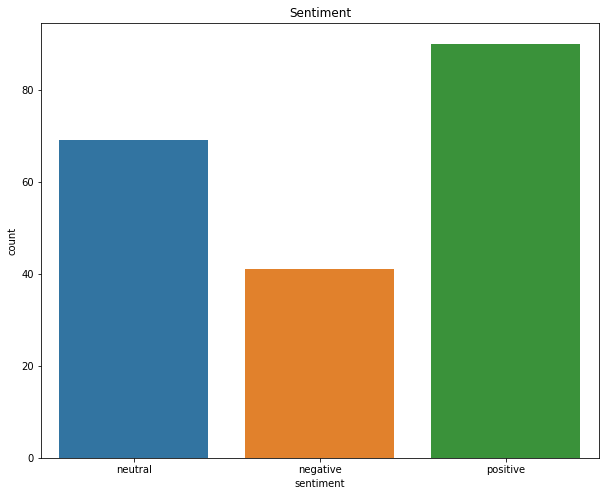

In [284]:
plt.figure(figsize = (10,8))
print(df['sentiment'].value_counts())
sns.countplot(df['sentiment'])
plt.title('Sentiment')

> Menarik melihat kebanyakan tweet-tweet di dataset ini positive untuk kata `AlbertEinstein`

# Modeling

## Dataset Splitting

In [285]:
X = df['Tweets']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160,) (40,) (160,) (40,)


Saya akan menggunakan MultinominalNaiveBayes dalam melakukan modeling

In [286]:
paramsNB = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'nb__alpha': [1, 1e-1]
}

In [287]:
model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [288]:
model_tuned = GridSearchCV(model, paramsNB, cv=3, scoring = 'f1_macro')
model_tuned.fit(X_train, y_train)

print(model_tuned.best_params_)

{'nb__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [289]:
print(classification_report(y_test, model_tuned.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

    negative       0.40      0.40      0.40         5
     neutral       0.89      0.44      0.59        18
    positive       0.54      0.82      0.65        17

    accuracy                           0.60        40
   macro avg       0.61      0.56      0.55        40
weighted avg       0.68      0.60      0.59        40



> Seharusnya model bisa lebih baik lagi, namun dikarenakan di project ini bukan untuk mencari model terbaik. Melainkan untuk melihat sentiment analysis di twitter, jadi saya rasa cukup. 

# Sanity Check

In [290]:
model_tuned.best_estimator_.predict(['Albert Einstein is considered the greatest scientist by many'])

array(['positive'], dtype='<U8')